# Beta Diversity

## What is beta diversity?

- Beta diversity is a distance or dissimilarity between two samples based on their composition

## Why do we care about beta diversity?

Beta diversity gives us ways to quantify how similar or dissimilar two samples are. We can then extrapolate this to comparing microbial communities across metadata variables. For example, are gut microbiome samples generally more similar to other gut microbiome samples or to oral microbiome samples?

## Quantifying beta diversity

### Beta diversity as a pairwise metric

Beta diversity is a **pairwise** metric, meaning each value exists for comparing a pair of samples. Each value is the distance (or dissimilarity) between the two samples.

For example, we can consider the pairwise distances between cities in the Colorado Front Range:

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [163]:


cities = ["Boulder", "Denver", "Golden", "Fort Collins", "Colorado Springs"]

# distances are given in miles
distances = np.array([[0, 24, 18, 39, 85],
                      [24, 0, 13, 56, 63],
                      [18, 13, 0, 56, 67],
                      [39, 56, 56, 0, 119],
                      [85, 63, 67, 119, 0]])

distances_df = pd.DataFrame(distances,
                            columns=cities,
                            index=cities)

distances_df

,Boulder,Denver,Golden,Fort Collins,Colorado Springs
Boulder,0,24,18,39,85
Denver,24,0,13,56,63
Golden,18,13,0,56,67
Fort Collins,39,56,56,0,119
Colorado Springs,85,63,67,119,0


In this case, because we have pairwise distances, we can't ask "What's the distance of Boulder?" Likewise, in a microbiome setting, we can't ask "What's the beta diversity of sample A?" Instead, we have to ask the question relative to another city/sample. For example, we can ask "What's the distance from Boulder to Fort Collins?" or "What's the the beta diversity between samples A and B?"

We can view distance matrices as heatmaps for a nice visual. You can see below that the color of each square represents the distance between the two corresponding cities. 

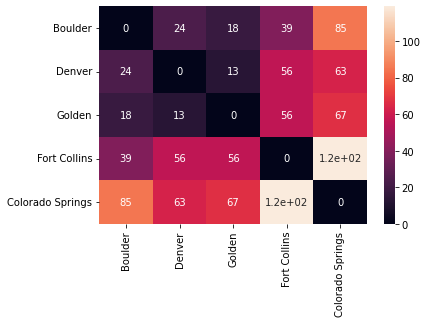

In [195]:
sns.heatmap(distances_df, annot=True)
plt.show()

### Quantitative vs qualitative beta diversity metrics

Some beta diversity metrics look at what taxa are present, but others look at how much of each taxon is there. These are referred to as qualitative and quantitative metrics, respectively. Two common examples are Jaccard distance and Bray-Curtis distance.

**Jaccard distance** is typically used on presence-absence data, and it is the portion of detected taxa that are shared between samples. The equation to calculate Jaccard distance can be seen below, where $J(A,B)$ is the number of taxa shared between the two samples divided by the total number of unique taxa in the two samples.
$$J(A,B) = 1 - \frac{A \cap B}{A \cup B}$$

- Note: if all taxa are shared between the two samples, Jaccard distance will be 0, regardless of the number of taxa. This is why Jaccard is considered a qualitative metric.

**Bray-Curtis distance**, however takes taxa abundances into account. The equation to calculate Bray-Curtis distance can be seen below, where the Bray-Curtis distance between samples A and B is the sum of difference between taxon $i$ in samples A and B divided by the total abundance of taxon $i$ across both samples for all taxa present in the two samples.

$$BC(A,B) = \sum_{i=1}^n \frac{|x_{A,i}-x_{B,i}|}{|x_{A,i}|+|x_{B,i}|}$$

- Q: What happens when there is no difference between the abundances of any taxa in samples A and B?
  - A: The numerator of all terms is 0, meaning that the Bray-Curtis distance is 0!
- Note: Even if all taxa are shared, if they have different abundances, Bray-Curtis distance will not be zero! This is why it can be considered a quantitative metric.

### A simple example

Let's consider an example where we've collected data on how many cats, fish, and bird that Will, Micaela, and Quinn have as pets.

In [137]:
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

In [156]:
a = [1, 0, 3]
b = [9, 0, 3]
c = [0, 2, 0]

pet_types = ["cats", "fish", "birds"]
names = ["Will", "Micaela", "Quinn"]

pets = pd.DataFrame([a,b,c],
                     columns=pet_types,
                     index=names)
pets

,cats,fish,birds
Will,1,0,3
Micaela,9,0,3
Quinn,0,2,0


**Stop here to answer these questions!**
- Q: From looking at the data, what would you expect the Jaccard distance between Will and Micaela to be? 
- What about the Jaccard distance from Will to Quinn? 
- Will Jaccard(Will, Micaela) = BC(Will, Micaela) ?

Let's investigate:

In [164]:
def create_and_show_dist_mat(data, ids, metric, annot=False):
    """
    This function makes a distance matrix and shows a heatmap of it.
    
Parameters
    ----------
    data : pd.DataFrame or NumPy array/matrix
        The data to calculate the distance matrix from.
    ids : list
        The list of sample IDs
    metric: str
        The distance metric to be used when creating the distance matrix.
        See https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
        for list of compatible metrics
    annot: Bool
        Provide True if the distances should be written in the heatmap.
        
    Returns
    -------
    dist: pd.DataFrame
        The generated distance matrix
    """
    dist = squareform(pdist(data, metric))
    dist = pd.DataFrame(dist,
                        columns=ids,
                        index=ids)
    
    ax = sns.heatmap(dist, linewidths=1, annot=annot)
    ax.set_title(f"{metric} distance")
    plt.show()
    return dist

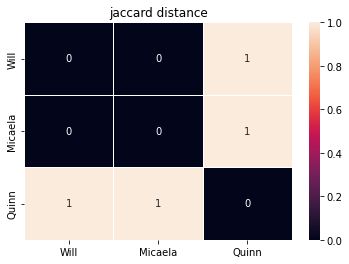

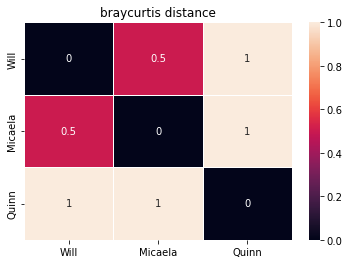

In [166]:
presence_absence_pets = pets.apply(lambda x: x > 0)
jaccard = create_and_show_dist_mat(presence_absence_pets, names, 
                                   metric="jaccard", annot=True)

bray_curt = create_and_show_dist_mat(pets, names, 
                                     metric="braycurtis", annot=True)

**Answers:**

- Jaccard distance from Will to Micaela is 0, since they share the same types of pets
- Jaccard distance from Will to Quinn is 1, since they share none of the same types of pets
- Jaccard(Will,Micaela) is not equal to BC(Will,Micaela)! This is because Jaccard only cares that they both have cats and birds, but Bray-Curtis is taking into account the fact that Micaela has 9 cats while Will only has 1.

### A more complex example

For a more complex example, let's imagine we look for common ingredients in 10 people's shopping carts at the grocery store...

In [254]:
foods = ["apples", "bananas",
         "broccoli","spinach",
         "chicken", "beef",
         "milk", "orange juice","apple juice",
         "cookies"
]

people = [f"Person {x}" for x in np.arange(1,11)]

# make some sparse data
data = sparse.random(10,10, density=0.5, random_state=42)
# turn that data to integers from 1 to 10
data = round((data*10))

# make a dataframe where rows are people
# and columns are foods
data = pd.DataFrame(data.A,
                    columns=foods,
                    index=people)

#convert to integers
data = data.astype(int)

data

,apples,bananas,broccoli,spinach,chicken,beef,milk,orange juice,apple juice,cookies
Person 1,1,4,0,7,2,0,0,8,9,3
Person 2,0,7,0,7,0,0,0,0,3,0
Person 3,0,8,9,0,7,0,4,6,0,0
Person 4,0,9,0,6,0,7,0,7,2,2
Person 5,6,0,0,1,9,0,0,0,0,0
Person 6,9,4,1,9,6,2,7,0,6,2
Person 7,0,6,0,0,0,0,6,4,0,9
Person 8,5,0,4,0,1,0,0,10,0,0
Person 9,0,4,5,0,0,0,0,0,3,0
Person 10,5,9,0,7,3,0,1,0,0,0


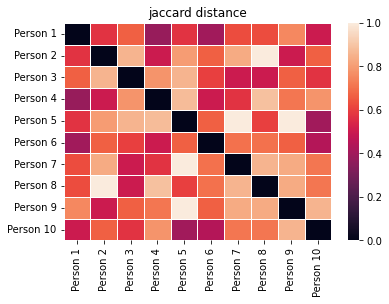

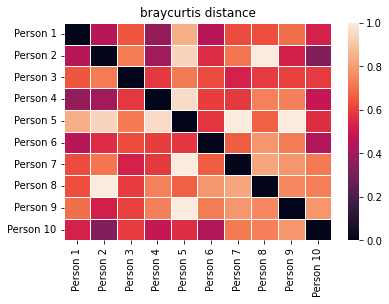

In [255]:
presence_absence_data = data.apply(lambda x: x > 0)
jaccard = create_and_show_dist_mat(presence_absence_data, people, metric="jaccard")

bray_curt = create_and_show_dist_mat(data, people, metric="braycurtis")

These look pretty similar, but they aren't exactly the same. For example, look at the color for the distance between individuals 1 and 5.

### UniFrac

In [289]:
from skbio import TreeNode
from skbio.diversity import beta_diversity
from io import StringIO

In [290]:
food_tree_str = """(((apples,bananas)fruit,(broccoli,spinach)vegetables)produce,
                     (chicken,beef)meat,(milk,(orange_juice,apple_juice)juice)beverages,
                     (cookies)sweets)items;"""

food_tree = TreeNode.read(StringIO(food_tree_str))

print(food_tree.ascii_art())

                              /-apples
                    /fruit---|
                   |          \-bananas
          /produce-|
         |         |          /-broccoli
         |          \vegetables
         |                    \-spinach
         |
         |          /-chicken
         |-meat----|
-items---|          \-beef
         |
         |          /-milk
         |-beverages
         |         |          /-orange juice
         |          \juice---|
         |                    \-apple juice
         |
          \sweets-- /-cookies


In [291]:
for node in food_tree.postorder():
    node.length=1

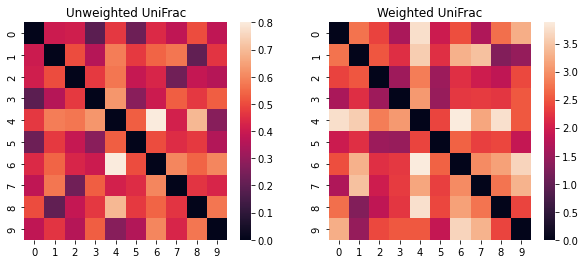

In [311]:
u_uni = beta_diversity(metric="unweighted_unifrac",
                       counts=data,
                       validate=False,
                       tree=food_tree,
                       ids=data.index,
                       otu_ids=data.columns)
w_uni = beta_diversity(metric="weighted_unifrac",
                       counts=data,
                       validate=False,
                       tree=food_tree,
                       ids=data.index,
                       otu_ids=data.columns)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].set_title("Unweighted UniFrac")
ax[1].set_title("Weighted UniFrac")
sns.heatmap(u_uni.data, ax=ax[0])
sns.heatmap(w_uni.data, ax=ax[1])
plt.show()

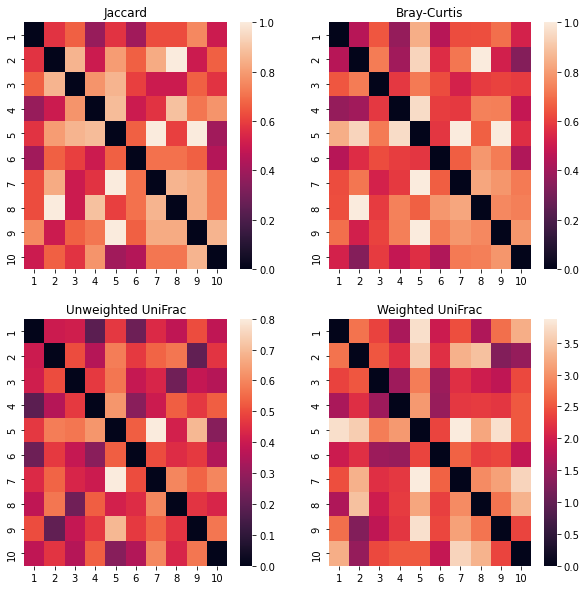

In [328]:
titles = np.array([["Jaccard", "Bray-Curtis"],
                   ["Unweighted UniFrac", "Weighted UniFrac"]])

matrices = np.array([[jaccard, bray_curt],
                    [u_uni.data, w_uni.data]])

fig, ax = plt.subplots(2,2, figsize=(10,10))

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_title(titles[i,j])
        sns.heatmap(matrices[i,j], 
                    xticklabels=range(1,11),
                    yticklabels=range(1,11),
                    ax=ax[i,j])

plt.show()

## Stats with beta diversity

### Correlations between distance matrices

How could we quantify how well these different distance matrices match each other? One way would be to look at the correlation between the values across the matrices. This is called a mantel test! We can perform a mantel test using Pearson or Spearman (non-parametric) correlations. 

Often, researchers use a mantel test to see how well beta diversity correlates with some metadata variable. This tells us how well microbiome composition correlates with that variable. 

Note: There are popular implementations of the mantel test in both Python (via scikit-bio) and R (via the vegan package). The mantel test 

In [256]:
from skbio.stats.distance import mantel

In [257]:
corr, p, n = mantel(jaccard, bray_curt)
print(f"Correlation coefficient = {corr}, \np = {p}")

Correlation coefficient = 0.7817190130125696, 
p = 0.001


## Using beta diversity

## Clustering

## Real world example

## Interactive example/homework